Necessary libraries

In [3]:
import pandas as pd
from IPython.display import HTML, display
#!pip install lightweight-charts pandas
import time
import warnings
import numpy as np
#import json # Para convertir el DataFrame a JSON para JavaScript
!pip install pandas -q
# Add this line to install tensorflow
!pip install tensorflow -q
from sklearn.preprocessing import MinMaxScaler # Data scaling 0 to 1
#warnings.filterwarnings('ignore')
# Import the matplotlib library for plotting
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

!pip install ipympl




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 597.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.8 MB/s eta 0:00:00


In [4]:
SEED = 42

tf.random.set_seed(SEED)

Load the .csv EURUSD file for analysis

In [6]:
df = pd.read_csv('EURUSD_5m_1Yea.csv')

Exploitation of the dataset

In [7]:
df

,Date,Time,Open,High,Low,Close,Volume
0,20240517,00:00:00,1.08679,1.08688,1.08659,1.08669,397760000
1,20240517,00:05:00,1.08670,1.08670,1.08654,1.08656,154750000
2,20240517,00:10:00,1.08656,1.08656,1.08644,1.08645,335080000
3,20240517,00:15:00,1.08645,1.08645,1.08618,1.08619,626080000
4,20240517,00:20:00,1.08619,1.08628,1.08615,1.08621,364680000
...,...,...,...,...,...,...,...
74627,20250516,20:35:00,1.11493,1.11493,1.11473,1.11475,152100001
74628,20250516,20:40:00,1.11475,1.11488,1.11446,1.11482,438530000
74629,20250516,20:45:00,1.11484,1.11544,1.11480,1.11532,679420000
74630,20250516,20:50:00,1.11530,1.11618,1.11522,1.11605,971410016


Checking for missing data

In [8]:
df.isnull().sum()

,0
Date,0
Time,0
Open,0
High,0
Low,0
Close,0
Volume,0


<Axes: >

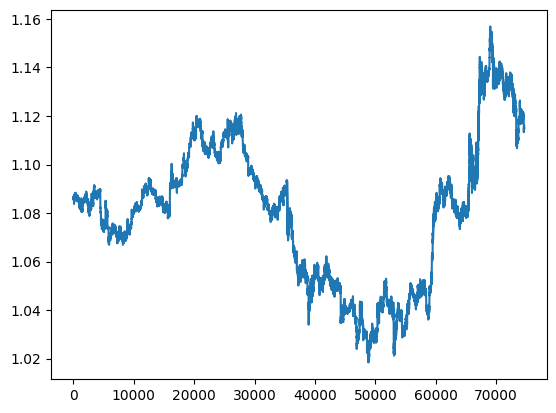

In [9]:
df['Close'].plot()

Data preparation

In [10]:
def create_dataset(data, time_steps):
  """
  Pre-organized data for training a Red Neural Recurrent

  prameters:
  data: time-series data
  time_steps: number of time steps for forecasting

  returns:
  dataX: input data
  dataY: output data

  """
  dataX, dataY = [], []
  for i in range(time_steps, len(data)):
    dataX.append(data[i-time_steps:i,0])
    dataY.append(data[i,0])
  return dataX, dataY

In [11]:
df = df[['Date','Close']]
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

<ipython-input-11-dd3cffc818d9>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 '1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 '1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 '1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 '1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 ...
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516',
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516',
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516',
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516',
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516']
Length: 74632, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'Date'] = pd.to_dat

In [12]:
train_size = int(0.6 * len(df)) # range for training
val_size = int(0.2 * len(df)) # range for validation
test_size = len(df) - train_size - val_size # testing lost data

train_df = df[0:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

print("Training data set size: ", train_size)
print("Validation data set size: ", val_size)
print("Test size: ", test_size)

Training data set size:  44779
Validation data set size:  14926
Test size:  14927


In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(train_df.Close.to_numpy().reshape(-1,1))
X_val = scaler.fit_transform(val_df.Close.to_numpy().reshape(-1,1))
X_test = scaler.fit_transform(test_df.Close.to_numpy().reshape(-1,1))

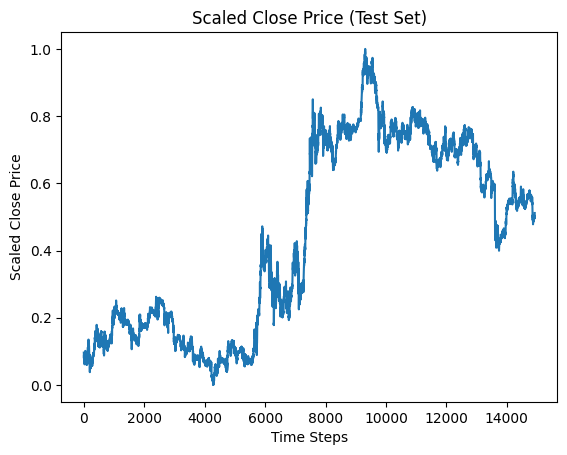

In [14]:
# Plot the X_test data
plt.plot(X_test)
plt.xlabel("Time Steps") # Optional: Add an x-axis label
plt.ylabel("Scaled Close Price") # Optional: Add a y-axis label
plt.title("Scaled Close Price (Test Set)") # Optional: Add a title
plt.show() # Display the plot

In [15]:
WINDOW = 100 # 288 in 5 minutes cycles in a Day

x_train, y_train = create_dataset(X_train, WINDOW)
x_val, y_val = create_dataset(X_val, WINDOW)
x_test, y_test = create_dataset(X_test, WINDOW)

Red LSTM according TFC Salvador Maceira

In [16]:
# Define the input shape based on your data (WINDOW time steps, 1 feature)
input_shape = (WINDOW, 1) # Assuming WINDOW is defined earlier in your code

# Build the Sequential model
model = Sequential()

# First LSTM layer with 50 units and the specified input shape
# For stacked LSTMs, all but the last LSTM layer need to return sequences
model.add(LSTM(50, return_sequences=True, input_shape=input_shape))

# First Dropout layer with a rate of 0.2
model.add(Dropout(0.2))

# Second LSTM layer with 50 units
# The last LSTM layer does not need return_sequences=True by default
model.add(LSTM(50))

# Second Dropout layer with a rate of 0.2
model.add(Dropout(0.2))

# Output Dense layer with 1 unit
model.add(Dense(1))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the model after defining it
model.compile(optimizer='adam', loss='mse') # Example compilation
callbacks = [EarlyStopping(patience=3)]

In [19]:
# Reshape the data for the LSTM model (samples, time steps, features)

x_train = np.array(x_train).reshape(len(x_train), WINDOW, 1)
x_val = np.array(x_val).reshape(len(x_val), WINDOW, 1)
x_test = np.array(x_test).reshape(len(x_test), WINDOW, 1)

# Convert y_train, y_val, and y_test to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Model training
model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=callbacks
    )

Epoch 1/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 91s 65ms/step - loss: 3.8943e-04 - val_loss: 1.8297e-04
Epoch 2/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 94s 67ms/step - loss: 3.8980e-04 - val_loss: 1.5372e-04
Epoch 3/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 91s 65ms/step - loss: 3.8436e-04 - val_loss: 8.9607e-05
Epoch 4/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 92s 66ms/step - loss: 3.8326e-04 - val_loss: 8.6791e-05
Epoch 5/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 92s 66ms/step - loss: 3.6713e-04 - val_loss: 2.0173e-04


In [20]:
print('MSE Train:', model.evaluate(x_train, y_train))
print('MSE Test:', model.evaluate(x_test, y_test))
print('MSE Val:', model.evaluate(x_val, y_val))

1397/1397 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 5.1037e-05
MSE Train: 8.36605322547257e-05
464/464 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 2.7280e-04
MSE Test: 0.00020172710355836898
464/464 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 2.0446e-04
MSE Val: 0.00020013841276522726


1397/1397 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
Length of y_train_orig: 44679
Length of train_dates: 44679
Length of y_val_orig: 14826
Length of val_dates: 14826
Length of y_test_orig: 14827
Length of test_dates: 14827
Generating plots...


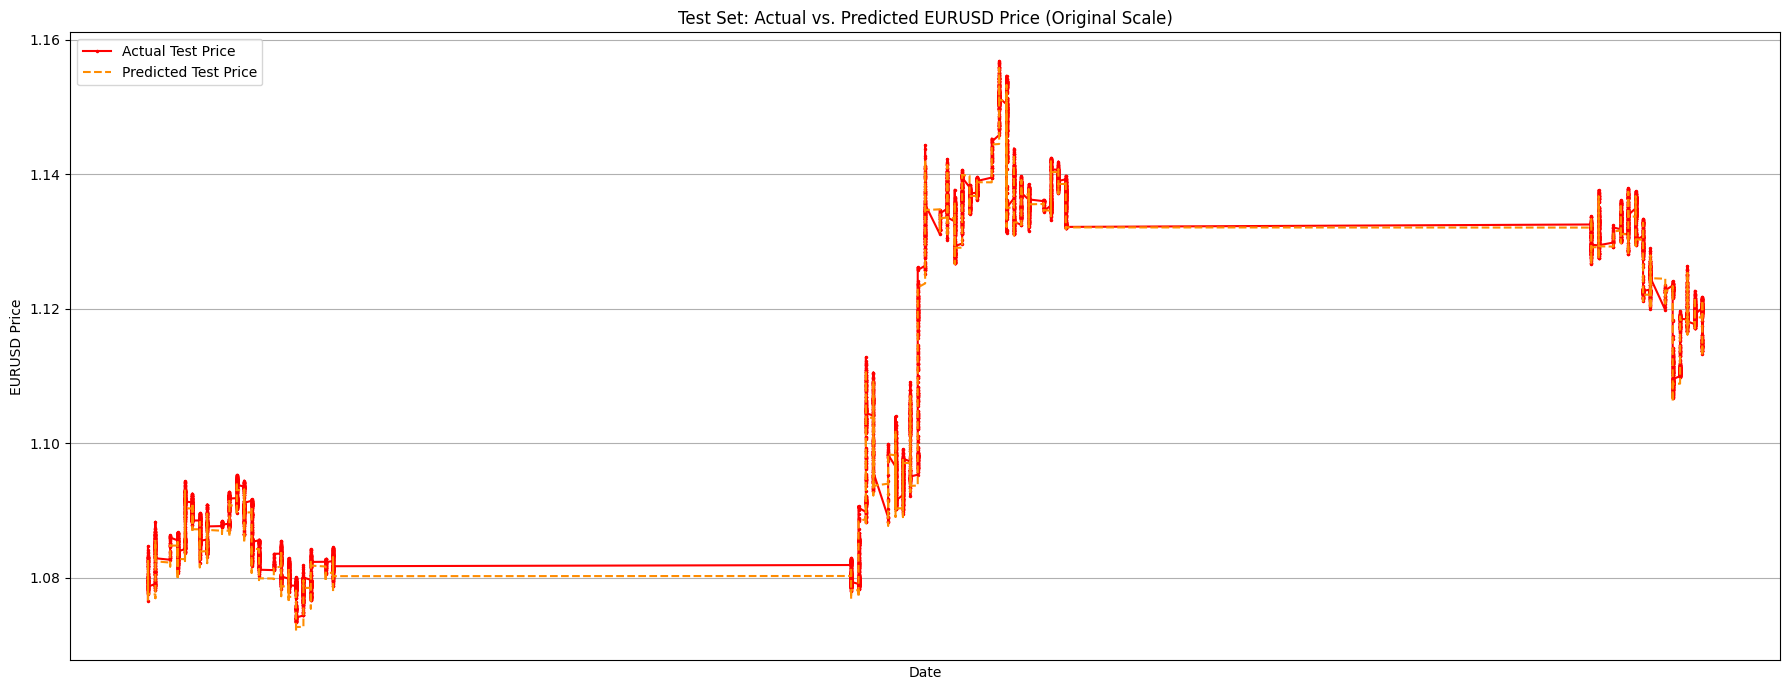

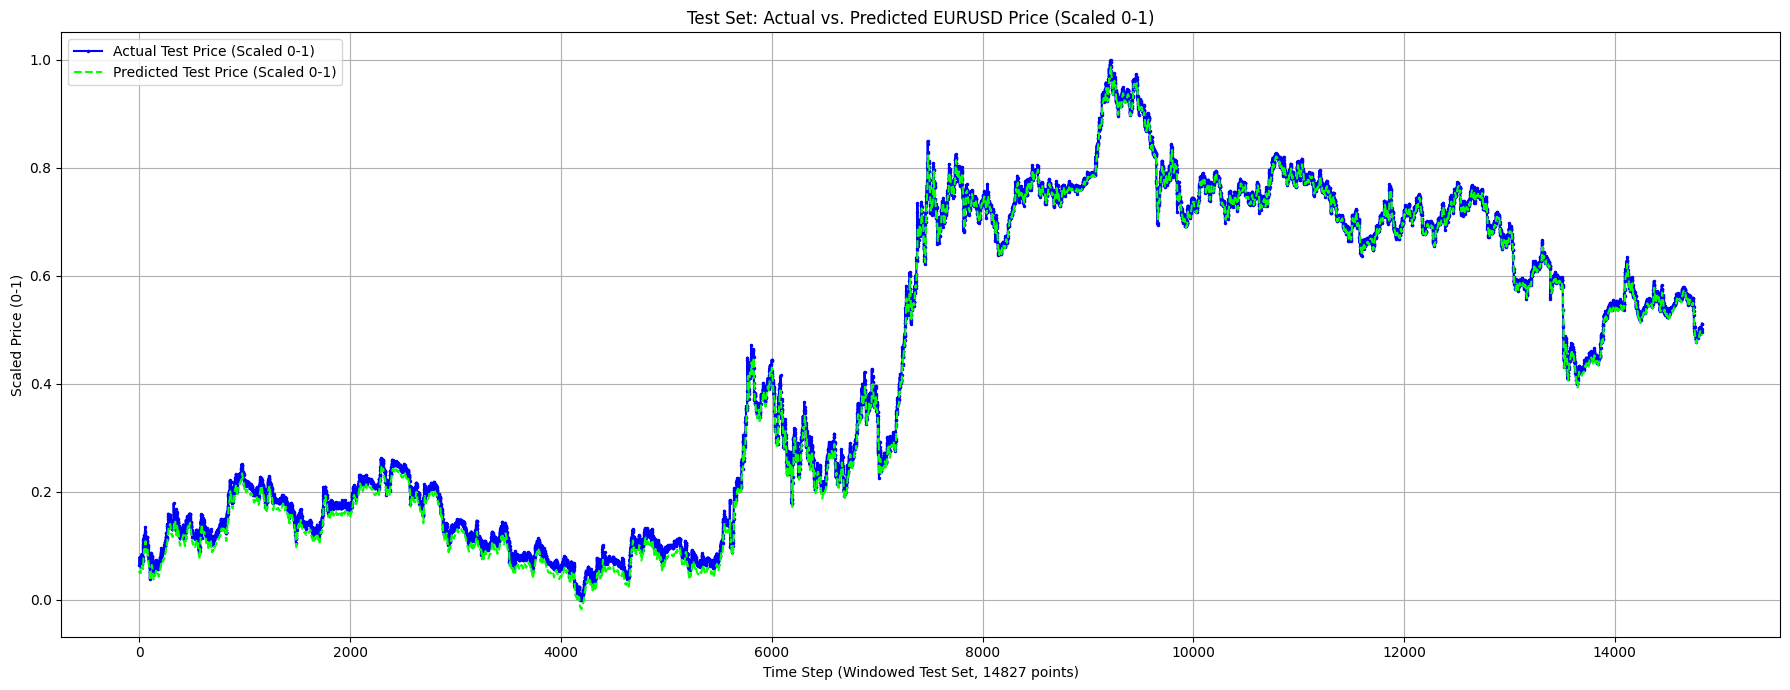

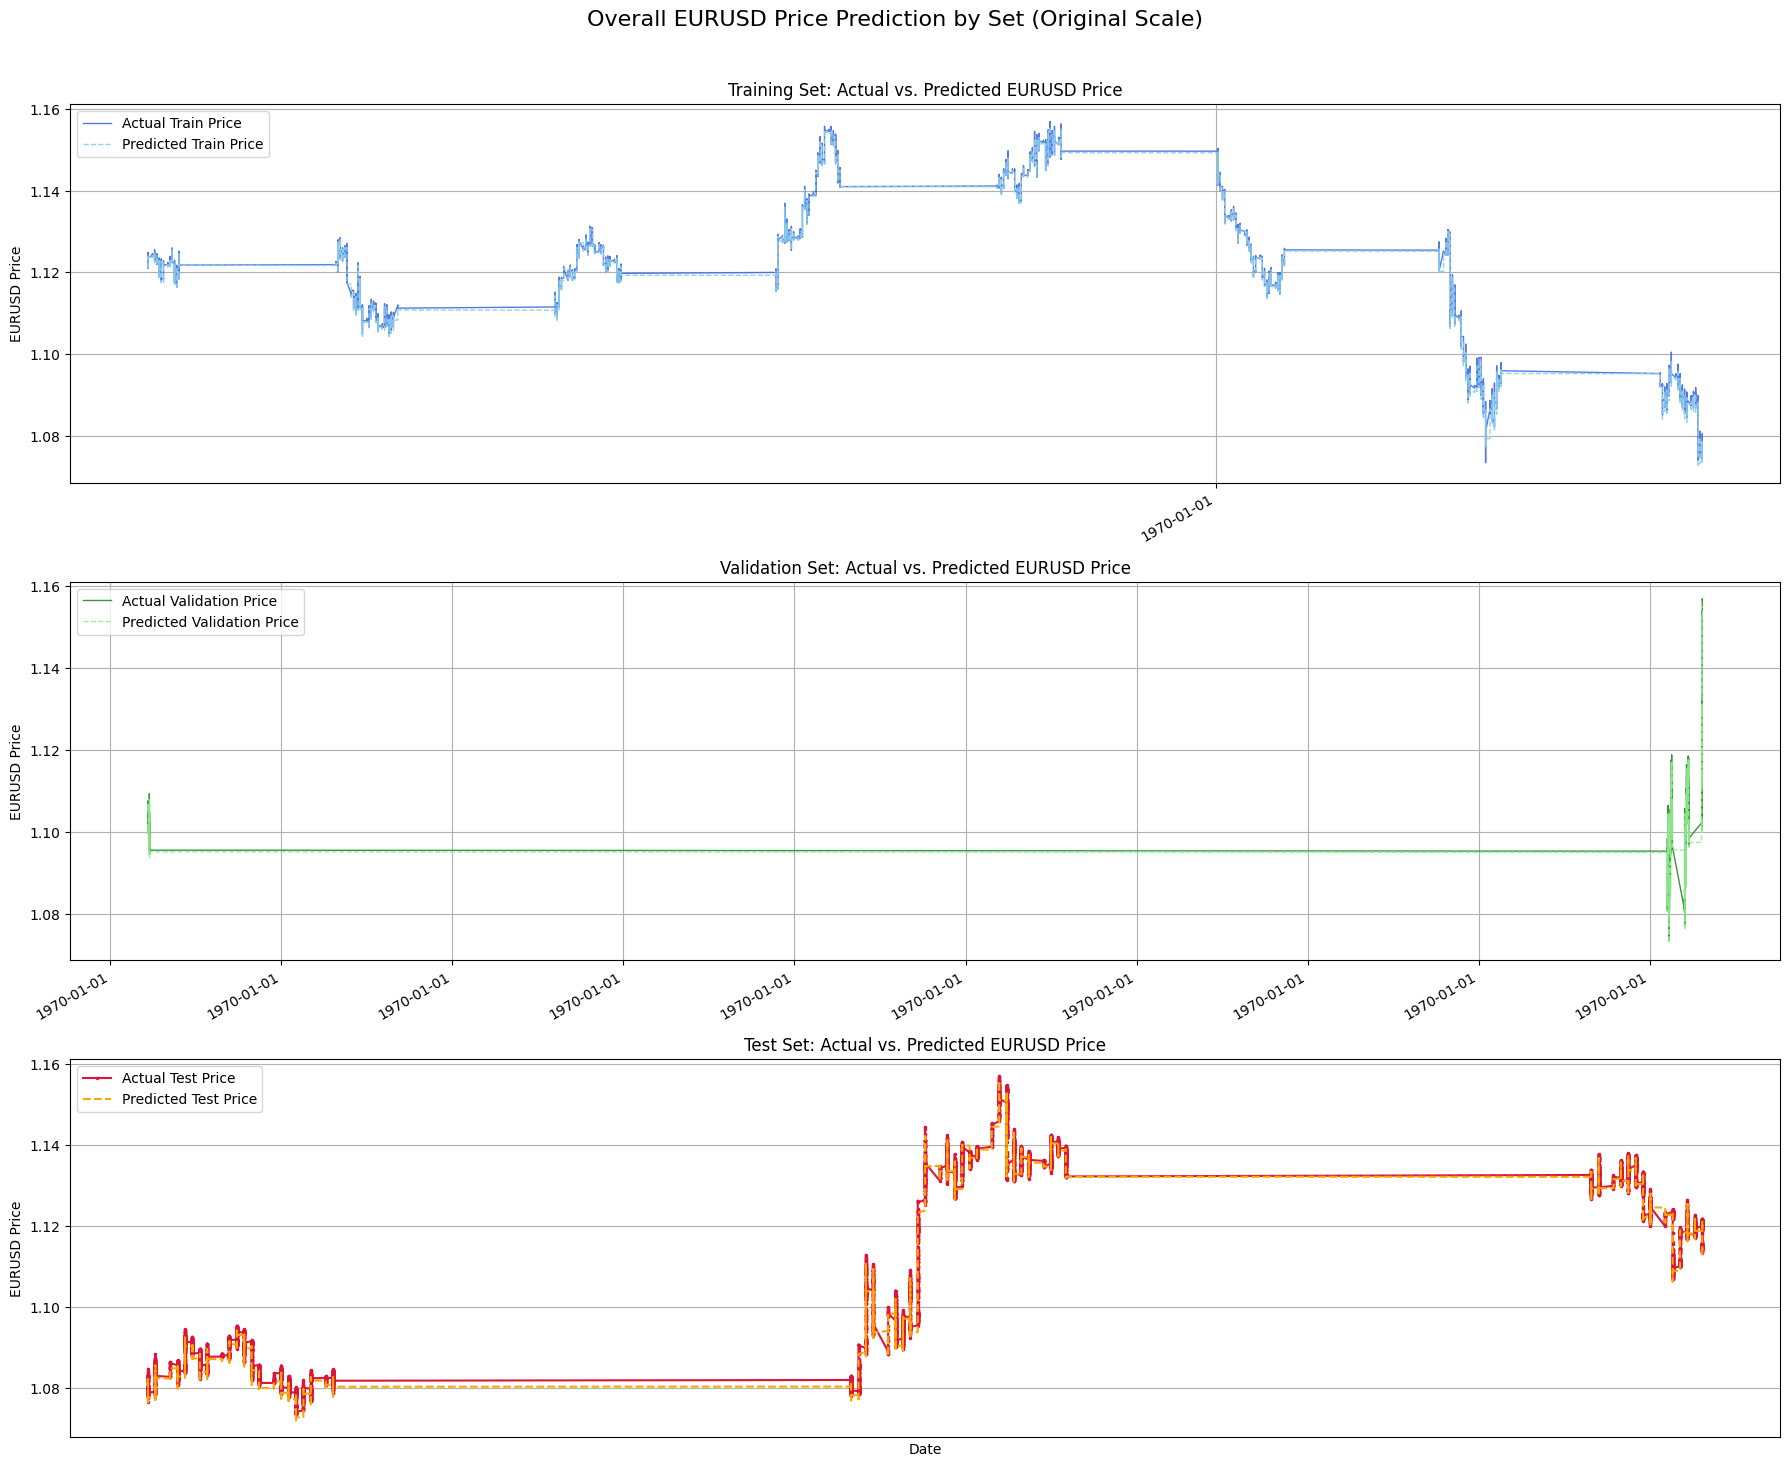

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Ensure this import is present
import numpy as np # Ensure numpy is imported for np.arange

# Make predictions on the scaled datasets
pred_train_scaled = model.predict(x_train)
pred_val_scaled = model.predict(x_val)
pred_test_scaled = model.predict(x_test)

# Inverse transform the scaled actual and predicted values to the original scale
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_train_orig = scaler.inverse_transform(pred_train_scaled)
y_pred_val_orig = scaler.inverse_transform(pred_val_scaled)
y_pred_test_orig = scaler.inverse_transform(pred_test_scaled)

# Extract dates for plotting
# Note: The dates should correspond to the *output* values (y) after windowing.
# The `create_dataset` function starts appending y from index `time_steps`.
train_dates = df['Date'][WINDOW : train_size].reset_index(drop=True)
val_dates = df['Date'][train_size + WINDOW : train_size + val_size].reset_index(drop=True)
test_dates = df['Date'][train_size + val_size + WINDOW :].reset_index(drop=True)

# Ensure the lengths match - this is crucial for plotting
# The number of dates should match the number of samples in y after windowing
# The windowed datasets (x_train, y_train, etc.) start from the `WINDOW` index
# of the respective split (train, val, test).
# For example, y_train corresponds to data points from index `WINDOW` to `train_size-1`
# of the original scaled training data (which was sliced from index 0 to train_size-1
# of the scaled X_train).

# Let's re-align the dates to match the windowed data.
# The original df index for the start of the training windowed data is WINDOW
# The original df index for the start of the validation windowed data is train_size + WINDOW
# The original df index for the start of the test windowed data is train_size + val_size + WINDOW

# Re-extract dates using the correct slicing based on the windowed data
train_dates = df['Date'].iloc[WINDOW : train_size].reset_index(drop=True)
val_dates = df['Date'].iloc[train_size + WINDOW : train_size + val_size].reset_index(drop=True)
test_dates = df['Date'].iloc[train_size + val_size + WINDOW :].reset_index(drop=True)


print(f"Length of y_train_orig: {len(y_train_orig)}")
print(f"Length of train_dates: {len(train_dates)}")
print(f"Length of y_val_orig: {len(y_val_orig)}")
print(f"Length of val_dates: {len(val_dates)}")
print(f"Length of y_test_orig: {len(y_test_orig)}")
print(f"Length of test_dates: {len(test_dates)}")

# Check if lengths match before plotting
if len(y_train_orig) != len(train_dates):
    print("Warning: Length of y_train_orig and train_dates do not match!")
if len(y_val_orig) != len(val_dates):
    print("Warning: Length of y_val_orig and val_dates do not match!")
if len(y_test_orig) != len(test_dates):
    print("Warning: Length of y_test_orig and test_dates do not match!")

print("Generating plots...")

# --- PLOT 1: Detailed Test Set Comparison (Original Price Scale) ---
fig1, ax1 = plt.subplots(figsize=(18, 7)) # Create figure and axes
ax1.plot(test_dates, y_test_orig, color='red', marker='.', linestyle='-', markersize=3, label='Actual Test Price')
ax1.plot(test_dates, y_pred_test_orig, color='darkorange', linestyle='--', linewidth=1.5, label='Predicted Test Price')

ax1.set_title('Test Set: Actual vs. Predicted EURUSD Price (Original Scale)')
ax1.set_xlabel('Date')
ax1.set_ylabel('EURUSD Price')
ax1.legend(loc='upper left')
ax1.grid(True)

# Improve date ticks on x-axis for ax1
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.setp(ax1.get_xticklabels(), rotation=30, ha='right') # Use plt.setp for properties
fig1.tight_layout() # Apply tight_layout to the figure
plt.show()

# --- PLOT 2: Detailed Test Set Comparison (Scaled 0-1 Price Scale) ---
fig2, ax2 = plt.subplots(figsize=(18, 7)) # Create figure and axes
time_steps_test = np.arange(len(y_test)) # y_test is scaled actuals for test
ax2.plot(time_steps_test, y_test, color='blue', marker='.', linestyle='-', markersize=3, label='Actual Test Price (Scaled 0-1)')
ax2.plot(time_steps_test, pred_test_scaled, color='lime', linestyle='--', linewidth=1.5, label='Predicted Test Price (Scaled 0-1)')

ax2.set_title('Test Set: Actual vs. Predicted EURUSD Price (Scaled 0-1)')
ax2.set_xlabel(f'Time Step (Windowed Test Set, {len(y_test)} points)')
ax2.set_ylabel('Scaled Price (0-1)')
ax2.legend(loc='upper left')
ax2.grid(True)
fig2.tight_layout() # Apply tight_layout to the figure
plt.show()

# --- PLOT 3: Overall View with Separate Subplots (Original Scale) ---
fig3, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=False) # sharex=False as time ranges are distinct

# Subplot 1: Training Data
axes[0].plot(train_dates, y_train_orig, color='royalblue', label='Actual Train Price', alpha=0.9, linewidth=1)
axes[0].plot(train_dates, y_pred_train_orig, color='skyblue', linestyle='--', label='Predicted Train Price', alpha=0.9, linewidth=1)
axes[0].set_title('Training Set: Actual vs. Predicted EURUSD Price')
axes[0].set_ylabel('EURUSD Price')
axes[0].legend(loc='upper left')
axes[0].grid(True)
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=12, tz=None))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Show only date for broader view
plt.setp(axes[0].get_xticklabels(), rotation=30, ha='right')

# Subplot 2: Validation Data
axes[1].plot(val_dates, y_val_orig, color='forestgreen', label='Actual Validation Price', alpha=0.9, linewidth=1)
axes[1].plot(val_dates, y_pred_val_orig, color='lightgreen', linestyle='--', label='Predicted Validation Price', alpha=0.9, linewidth=1)
axes[1].set_title('Validation Set: Actual vs. Predicted EURUSD Price')
axes[1].set_ylabel('EURUSD Price')
axes[1].legend(loc='upper left')
axes[1].grid(True)
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=12, tz=None))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Show only date
plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')

# Subplot 3: Test Data
axes[2].plot(test_dates, y_test_orig, color='crimson', marker='.', linestyle='-', markersize=3, label='Actual Test Price')
axes[2].plot(test_dates, y_pred_test_orig, color='orange', linestyle='--', linewidth=1.5, label='Predicted Test Price')
axes[2].set_title('Test Set: Actual vs. Predicted EURUSD Price')
axes[2].set_xlabel('Date') # Only set xlabel for the bottom-most plot
axes[2].set_ylabel('EURUSD Price')
axes[2].legend(loc='upper left')
axes[2].grid(True)
axes[2].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15, tz=None))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) # Date and Time for test
plt.setp(axes[2].get_xticklabels(), rotation=30, ha='right')

fig3.suptitle('Overall EURUSD Price Prediction by Set (Original Scale)', fontsize=16, y=1.005)
fig3.tight_layout(rect=[0, 0.03, 1, 0.99]) # Adjust rect to make space for suptitle and bottom labels
plt.show()